In [1]:
!pip install pandas
!pip install tqdm
!pip install -U scikit-learn scipy matplotlib


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.8/dist-packages (1.0.2)
Requirement already up-to-date: scipy in /usr/local/lib/python3.8/dist-packages (1.8.0)
Requirement already up-to-date: matplotlib in /usr/local/lib/python3.8/dist-packages (3.5.1)
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [12]:
import os

import datetime as dt
import pandas as pd
import numpy as np
import pandas as pd
import tqdm
import random
import pylab
import random

from datetime import datetime, timedelta
from dateutil import parser
from numpy import array
from tensorflow.keras.layers import Dense, LSTM,GRU
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import Sequential
from collections import Counter
from pandas import DataFrame
from enum import Enum
from matplotlib import pyplot

%matplotlib inline 


In [13]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence) - 1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]

        seq_x = np.pad(seq_x, ((0, 0), (0, 30 - seq_x.shape[1])), 'constant')
        X.append(seq_x)
        y.append(seq_y[-1])
    return array(X), array(y)

In [40]:
from matplotlib import pyplot as plt
def draw_timeline(name,vulns,first_date, last_date):

    dates = vulns
    dates += [first_date]
    dates += [last_date]

    values = [1]*len(dates)
    values[-1] = 2
    values[-2] = 2

    X = pd.to_datetime(dates)
    fig, ax = plt.subplots(figsize=(6,1))
    ax.scatter(X, [1]*len(X), c=values,
               marker='s', s=100)
    fig.autofmt_xdate()

    # everything after this is turning off stuff that's plotted by default
    ax.set_title(name)
    ax.yaxis.set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['top'].set_visible(True)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_facecolor('white')
    
    ax.get_yaxis().set_ticklabels([])
    # day = pd.to_timedelta("1", unit='D')
    # plt.xlim(X[0] - day, X[-1] + day)
    plt.show()
    #plt.subplots_adjust(bottom=0.15)
    #plt.savefig(f"D:/cve/images/timeline/{name}.jpg", transparent=False)
    
    
def find_benign_events(cur_repo_data,gap_days, num_of_events):
    benign_events = []
    retries = num_of_events * 5
    counter = 0
    for _ in range(num_of_events):
        found_event = False
        while not found_event:
            if counter >=retries:
                return benign_events
            try:
                cur_event = random.randint(2*gap_days+1,cur_repo_data.shape[0]-gap_days*2-1)
            except ValueError:
                counter +=1
                continue
            event = cur_repo_data.index[cur_event]

            before_vuln = event - gap_days
            after_vuln = event + gap_days
            res_event = cur_repo_data[before_vuln:event-1]
            if not res_event[res_event["VulnEvent"]>0].empty:
                counter +=1
                continue
            benign_events.append(res_event.iloc[:,:-1].values)
            found_event = True
            
            
    return benign_events

def create_all_events(cur_repo_data,gap_days):
    all_events = []
    labels = []
    for i in range(gap_days,cur_repo_data.shape[0],1):
            event = cur_repo_data.index[i]
            before_vuln = event - gap_days
            res_event = cur_repo_data[before_vuln:event-1]
            all_events.append(res_event.iloc[:,:-1].values)
            labels.append(res_event.iloc[:,-1].values)
    return all_events,labels


def add_time_one_hot_encoding(df):
    # print(df.index.day_of_week)
    # print(df.index.hour)
    hour = pd.get_dummies(df.index.hour.astype(pd.CategoricalDtype(categories=range(24))),prefix='hour')
    week = pd.get_dummies(df.index.day_of_week.astype(pd.CategoricalDtype(categories=range(7))),prefix='day_of_week')
    day_of_month = pd.get_dummies(df.index.day.astype(pd.CategoricalDtype(categories=range(1,32))),prefix='day_of_month')

    df = pd.concat([df.reset_index(),hour,week,day_of_month],axis=1)
    # df = df.set_index('index')
    return df

def get_event_window(cur_repo_data, event, aggr_options, days=10, hours=10,resample=24):
    starting_time = event - timedelta(days=days,hours=hours)
    res = cur_repo_data[starting_time:event]

    if aggr_options == Aggregate.before_cve:
        res = res.iloc[:-1,:]
        res = res.resample(f'{resample}H').sum()
        res = add_time_one_hot_encoding(res)
        
    elif aggr_options == Aggregate.after_cve:
        res = res.iloc[:-1,:]
        new_row = pd.DataFrame([[0]*len(res.columns)], columns = res.columns, index=[starting_time])
        res = pd.concat([new_row,res], ignore_index=False)
        res = res.resample(f'{resample}H').sum()
        res = add_time_one_hot_encoding(res)
        
    else:
        res = add_time_one_hot_encoding(res)
        res = res.reset_index(drop=True)

    return res

def find_best_f1(X_test,y_test,model):
    max_f1 = 0
    thresh = 0
    best_y = 0
    pred = model.predict(X_test)
    for i in range(100):
        y_predict = (pred.reshape(-1)>i/1000).astype(int)
        precision, recall, fscore, support = score(y_test,y_predict ,zero_division=0)
        cur_f1 = fscore[1]
        # print(i,cur_f1)
        if cur_f1 > max_f1:
            max_f1 = cur_f1
            best_y = y_predict
            thresh = i / 100
    return max_f1,thresh, best_y

import itertools

def generator(feat,labels):
    pairs = [(x, y) for x in feat for y in labels]
    cycle_pairs = itertools.cycle(pairs)
    for a,b in pairs:
        yield np.array([a]), np.array([b])
    return

In [41]:
repo_dirs = '../repo_gharchive_processed4'
benign_all, vuln_all = [], []
n_features = 0
gap_days = 150

nice_list= ['facebook_hhvm.csv',
'ffmpeg_ffmpeg.csv',
'flatpak_flatpak.csv',
'freerdp_freerdp.csv',
'git_git.csv',
'gpac_gpac.csv',
'imagemagick_imagemagick.csv',
'kde_kdeconnect-kde.csv',
'krb5_krb5.csv',
'mantisbt_mantisbt.csv',
'op-tee_optee_os.csv',
'owncloud_core.csv',
'php_php-src.csv',
'revive-adserver_revive-adserver.csv',
'rubygems_rubygems.csv',
'the-tcpdump-group_tcpdump.csv']

class Aggregate(Enum):
    none = 1
    before_cve = 2
    after_cve = 3
    
aggr_options = Aggregate.none

num_of_events = 10
days = 50
hours = 0
resample = 12
benign_vuln_ratio = 1

In [ ]:
for file in os.listdir(repo_dirs)[:]:
    try:
        selected = 4
        if file not in nice_list[:]:
                  continue
        cur_repo_data = pd.read_csv(repo_dirs + "/" + file,parse_dates=['created_at'],index_col='created_at')

        if cur_repo_data.shape[0]<100:
            continue

        cur_repo_data = cur_repo_data[cur_repo_data.index.notnull()]
        cur_repo_data["additions"]=(cur_repo_data["additions"]-cur_repo_data["additions"].mean())/cur_repo_data["additions"].std()
        cur_repo_data["deletions"]=(cur_repo_data["deletions"]-cur_repo_data["deletions"].mean())/cur_repo_data["deletions"].std()

    except pd.errors.EmptyDataError:
        continue


    cols_at_end = ['VulnEvent']
    cur_repo_data = cur_repo_data[[c for c in cur_repo_data if c not in cols_at_end]
                            + [c for c in cols_at_end if c in cur_repo_data]]

    vulns = cur_repo_data.index[cur_repo_data['VulnEvent'] > 0].tolist()
    benigns = cur_repo_data.index[cur_repo_data['VulnEvent'] == 0].tolist()
    random.shuffle(benigns)
    for vuln in vulns:
        res = get_event_window(cur_repo_data,vuln,aggr_options,days=days,hours=hours,resample=resample)
        vuln_all.append(res.values)
    print(file)
    benign_counter = 0
    for benign in tqdm.tqdm(benigns):
        if benign_counter >= benign_vuln_ratio*len(vulns):
            break

        res = get_event_window(cur_repo_data,benign,aggr_options,days=days,hours=hours,resample=resample)
        benign_all.append(res.values)            
        benign_counter+=1
    print(file)

facebook_hhvm.csv


  0%|          | 143/127065 [00:01<22:25, 94.35it/s] 


facebook_hhvm.csv
ffmpeg_ffmpeg.csv


  0%|          | 339/142290 [00:02<19:13, 123.05it/s]


ffmpeg_ffmpeg.csv
flatpak_flatpak.csv


  1%|          | 383/41975 [00:03<05:26, 127.45it/s]


flatpak_flatpak.csv
freerdp_freerdp.csv


  2%|▏         | 600/36864 [00:02<03:01, 200.12it/s]


freerdp_freerdp.csv
git_git.csv


  0%|          | 144/241288 [00:01<46:48, 85.87it/s]


git_git.csv
gpac_gpac.csv


  1%|          | 224/33984 [00:01<02:57, 190.26it/s]


gpac_gpac.csv
imagemagick_imagemagick.csv


  2%|▏         | 475/29878 [00:02<02:08, 228.11it/s]


imagemagick_imagemagick.csv
kde_kdeconnect-kde.csv


  3%|▎         | 132/4859 [00:00<00:17, 273.82it/s]


kde_kdeconnect-kde.csv
krb5_krb5.csv


  0%|          | 140/28749 [00:00<01:50, 258.53it/s]


krb5_krb5.csv
mantisbt_mantisbt.csv


  1%|          | 212/27782 [00:01<02:10, 211.81it/s]


mantisbt_mantisbt.csv
op-tee_optee_os.csv


  2%|▏         | 286/12129 [00:01<00:49, 238.76it/s]


op-tee_optee_os.csv
owncloud_core.csv


  0%|          | 110/405489 [00:05<5:42:57, 19.70it/s]


owncloud_core.csv
php_php-src.csv


  0%|          | 211/279744 [06:09<3158:25:18, 40.68s/it]

In [ ]:
max_vals = max(Counter([v.shape for v in vuln_all]))
vuln_all = [v for v in vuln_all if v.shape == max_vals]
max_vals = max(Counter([v.shape for v in benign_all]))
benign_all = [v for v in benign_all if v.shape == max_vals]

vuln_all =np.nan_to_num(np.array(vuln_all))
benign_all = np.nan_to_num(np.array(benign_all)) 
name_template = f"{str(aggr_options)}_{benign_vuln_ratio}_H{hours}_D{days}_R{resample}"
vuln_npy_name = name_template+"_vuln.npy"
benign_npy_name = name_template+"_benign.npy"

np.save("ready_data/"+vuln_npy_name, np.array(vuln_all))    # .npy extension is added if not given
np.save("ready_data/"+benign_npy_name, np.array(benign_all))    # .npy extension is added if not given

In [ ]:
name_template = f"{str(aggr_options)}_{benign_vuln_ratio}_H{hours}_D{days}_R{resample}"
print(name_template)
vuln_npy_name = name_template+"_vuln.npy"
benign_npy_name = name_template+"_benign.npy"

vuln_all = np.load("ready_data/"+vuln_npy_name)
benign_all = np.load("ready_data/"+benign_npy_name)
def normalize(time_series_feature):
    if time_series_feature.max()-time_series_feature.min() == 0:
        return time_series_feature
    return (time_series_feature-time_series_feature.min())/(time_series_feature.max()-time_series_feature.min())

In [ ]:
all_train_x = np.concatenate([vuln_all,benign_all])
all_train_y = np.concatenate([np.ones(vuln_all.shape[0]),np.zeros(benign_all.shape[0])])
all_train_x.shape,all_train_y.shape

NORMALIZE = True

if NORMALIZE:
    all_train_x= normalize(all_train_x)
    vuln_all = normalize(vuln_all)
    benign_all = normalize(benign_all)

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
print(all_train_x.shape, all_train_x[0].shape)
print(all_train_y.shape, all_train_y[0].shape)
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras import Input, layers
from tensorflow.keras.callbacks import EarlyStopping

X_train, X_test, y_train, y_test = train_test_split(all_train_x,all_train_y,shuffle=True)

In [ ]:
part = 1
X_train = X_train[:X_train.shape[0]//part,:,:]
X_test = X_test[:X_test.shape[0]//part,:,:]
y_train = y_train[:y_train.shape[0]//part]
y_test = y_test[:y_test.shape[0]//part]

In [ ]:
model1 = Sequential()
model1.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Flatten())
model1.add(Dense(100, activation='relu'))
model1.add(Dropout(0.50))
model1.add(Dense(50, activation='relu'))
model1.add(Dropout(0.50))
model1.add(Dense(25, activation='relu'))
model1.add(Dropout(0.50))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

reshaped_train,reshaped_test = X_train.reshape(X_train.shape[0],-1), X_test.reshape(X_test.shape[0],-1)

# define model
model2 = Sequential()
model2.add(Conv1D(filters=500, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model2.add(Dropout(0.7))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Dropout(0.3))
model2.add(Flatten())
model2.add(Dense(100, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(100, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(100, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(70, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(50, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(30, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', mode='max',patience=30)

history = model2.fit(X_test, y_test, verbose=1,epochs=200, validation_data=(X_train,y_train),callbacks=[])

# print(model.evaluate(X_test.reshape(X_test.shape[0],-1), y_test, verbose=0))
pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history['val_accuracy'])
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'val'], loc='upper left')
pyplot.show()


from sklearn.metrics import precision_recall_fscore_support as score



f1,thresh,best_y = find_best_f1(X_test,y_test,model2)
print(f1)

In [12]:
X_train.shape,y_train.shape

((5606, 101, 86), (5606,))

In [ ]:
for i in range(10):
    print(y_test[i])
    DataFrame(X_test[i,:,:24]).plot(title=y_test[i],legend=False)
    pyplot.show()
    import time
    time.sleep(3)

In [217]:
all_events = np.array(all_events)
all_events.shape
df = DataFrame(model.predict(all_events),columns=['pred'])

NameError: name 'all_events' is not defined

In [43]:
pred = model.predict(X_test).reshape(-1)
real = y_test
df = DataFrame(zip(real,pred),columns=['real','pred'])

<AxesSubplot:>

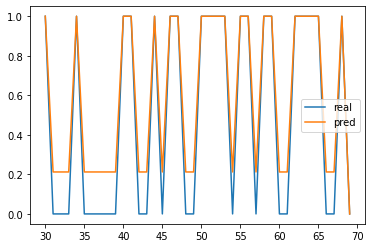

In [49]:
df.iloc[30:70].plot()

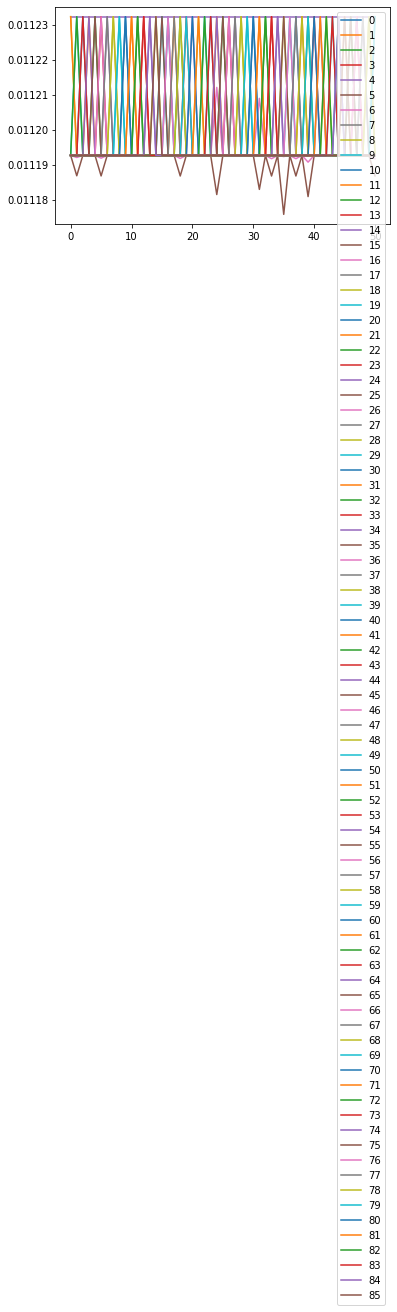

In [23]:
df = DataFrame(model.predict(X_test),columns=['pred'])
pd.DataFrame(X_test[1]).plot()
pyplot.show()

In [237]:
pd.DataFrame(y_test).iloc[:1000].plot()
len(benign_all),len(vuln_all)

(1338, 1465)

In [ ]:
# model.save("models/150back2000epochs_84valaccuracy")

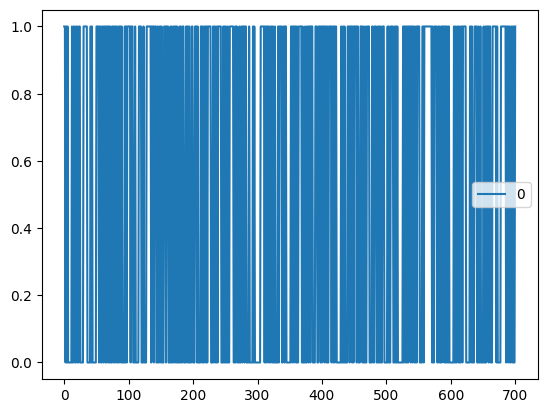

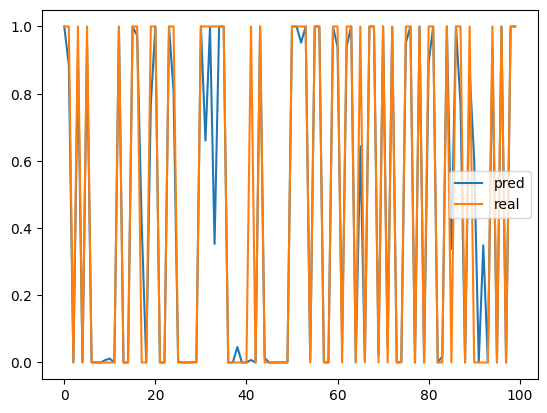

In [238]:
df['pred2'] = df['pred'].apply(lambda x: 0.0 if x < 0.3 else 1.0)
df['real']=y_test
df[['pred','real']].iloc[:100].plot()

pyplot.show()

0.6022727272727273


In [ ]:
print(model.evaluate(X_test.reshape(X_test.shape[0],-1), y_test, verbose=0))


In [ ]:
unshaped = X_test.reshape(X_test.shape[0],-1)

a = model.predict(unshaped)
from pandas import DataFrame
DataFrame(a).plot()

In [ ]:
res = pd.DataFrame(unshaped)
res['predict']=a
res['real']=y_test
res2=res

In [ ]:
res2=res
res2['predict']=res2['predict'].apply(lambda x: 0.0 if x<0.5 else 1.0)
res2[res['predict']!=res['real']]

In [ ]:
os.mkdir(models)
model.save(f'models/serial_1_4_f1_{f1}.h5')  # creates a HDF5 file 'my_model.h5'

In [ ]:
import tensorflow as tf
nb_epoch = 10
batch_size = 64
input_dim = benign_all2.shape[1] #num of columns, 30
encoding_dim = 14
hidden_dim_1 = int(encoding_dim / 2) #
hidden_dim_2=4  
learning_rate = 1e-7

#input Layer
input_layer = tf.keras.layers.Input(shape=(input_dim, ))
#Encoder
encoder = tf.keras.layers.Dense(encoding_dim, activation="tanh",                                activity_regularizer=tf.keras.regularizers.l2(learning_rate))(input_layer)
encoder=tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_2, activation=tf.nn.leaky_relu)(encoder)
# Decoder
decoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
decoder=tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.Dense(encoding_dim, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(input_dim, activation='tanh')(decoder)
#Autoencoder
autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)
#autoencoder.summary()

autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

history = autoencoder.fit(benign_all2, benign_all2,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(vuln_all2, vuln_all2),
                    verbose=1,
                    ).history

In [ ]:
vuln_all2.shape

In [ ]:
mall = np.concatenate([benign_all2,vuln_all2]) # .shape ,benign_all2.shape,vuln_all2.shape

In [ ]:

threshold_fixed = 0.1
check = vuln_all2
#mall = check
test_x_predictions1 = autoencoder.predict(vuln_all2)
# test_x_predictions2 = autoencoder.predict(mall[int(mall.shape[0]/2):])


In [ ]:
mse = np.mean(np.power(mall - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': len(benign_all2)*[0]+len(vuln_all2)*[1]})

In [ ]:
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(0.4, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
# plt.ylim([0,1])
plt.title("Reconstruction error for normal and fraud data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

In [ ]:
accuracy_score(predictions, [1]*len(vuln_all2))

In [ ]:
test_x_predictions = autoencoder.predict(test_data)
mse = np.mean(np.power(test_data - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_labels})
Plotting the test data points and their respective reconstruction error sets a threshold value to visualize if the threshold value needs to be adjusted.
threshold_fixed = 50
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and fraud data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();


from sklearn.metrics import accuracy_score
import tensorflow as tf
def find_threshold(model, x_train_scaled):
    reconstructions = model.predict(x_train_scaled)
    # provides losses of individual instances
    reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
    # threshold for anomaly scores
    threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
    return threshold

def get_predictions(model, x_test_scaled, threshold):
    predictions = model.predict(x_test_scaled)
    # provides losses of individual instances
    errors = tf.keras.losses.msle(predictions, x_test_scaled)
    # 0 = anomaly, 1 = normal
    anomaly_mask = pd.Series(errors) > threshold
    preds = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)
    return preds



In [ ]:
predictions = get_predictions(model, vuln_all2, threshold-0.000011)
accuracy_score(predictions, [0]*len(vuln_all2))

In [ ]:
for i in range(30):
    print(i,np.isnan(all_train_x[:,:,i]).any())
    

In [ ]:
all_train_x = all_train_x[:,:,:21]

In [ ]:
"""
model = Sequential()

model.add(LSTM(100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))

from keras.layers import RepeatVector
from keras.layers import TimeDistributed

model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), metrics=['accuracy'])
model.fit(X_train, y_train, epochs=100,validation_data=(X_test,y_test),verbose=1)
"""

"""model = Sequential()

model.add(LSTM(100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5,validation_data=(X_test,y_test),verbose=2)


"""



"""model = Sequential()
model.add(Dense(50, input_shape=[all_train_x.shape[1]], activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.1), metrics=['accuracy'])

"""

"""model = Sequential()
model.add(Dense(150,input_shape=[benign_all2.shape[1]], activation='linear')) 
model.add(Dense(75, activation="linear"))
model.add(Dense(10, activation="linear"))
model.add(Dense(75, activation="linear"))
model.add(Dense(benign_all2.shape[1], activation="linear"))
model.compile(optimizer='adam',loss='mse')
"""


